In [1]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
from matplotlib.patches import Patch
import matplotlib.lines as mlines

plt.rcParams["font.family"] = "Arial"

from utils.data_processing import process_string

from utils.icc_functions import (
    icc_daywise_combinations,
    icc_daywise_combinations_allcombos,
)


from tqdm import tqdm
from config.variables import (
    feature_color_assigner,
    nutri_fg_vars,
    nutri_cfg_vars,
    nutri_micro_vars,
)

## Load food intake data

In [2]:
df_food_filtered_agg = pd.read_csv("./data/df_food_filtered_agg.csv")

## Computing User-Level Feature Means as Baseline

This section calculates the mean value of each feature per user and assigns these means to "judge A". This serves as our baseline for comparison in the ICC analysis.

In [3]:
mean_of_feat_per_user = (
    df_food_filtered_agg.drop("day_of_week", axis=1)
    .groupby("subject_key")
    .mean()
    .reset_index()
)
mean_of_feat_per_user["judge"] = "A"

Computes the ICC (Intraclass Correlation Coefficient) values for different combinations of days until a threshold is reached.

In [4]:
# allFeats_icc_dayCombinations_withBreaks = pd.DataFrame()

# for col in tqdm(df_food_filtered_agg.columns[2:]):
#     res = icc_daywise_combinations(
#         df_food_filtered_agg, col, mean_of_feat_per_user, threshold=0.9
#     )
#     singleFeat_icc_dayCombinations_withBreaks = pd.DataFrame(
#         res, columns=["feature", "day_comb", "num_days", "icc"]
#     )
#     allFeats_icc_dayCombinations_withBreaks = pd.concat(
#         [
#             allFeats_icc_dayCombinations_withBreaks,
#             singleFeat_icc_dayCombinations_withBreaks,
#         ]
#     )

# allFeats_icc_dayCombinations_withBreaks.head()

In [5]:
# threshold = 0.9

# feat_min_days_icc_dict = (
#     allFeats_icc_dayCombinations_withBreaks[
#         allFeats_icc_dayCombinations_withBreaks["icc"] >= threshold
#     ]
#     .groupby("feature")["num_days"]
#     .min()
#     .sort_values()
# )
# feat_min_days_icc_dict

### Computing ICC (Intraclass Correlation Coefficient) values for all possible day combinations

The code below calculates ICC values for all possible combinations of days (1-6 days) for each feature, without stopping at a threshold. 

In [ ]:
allFeats_icc_dayCombinations_noBreaks = pd.DataFrame()

for col in tqdm(df_food_filtered_agg.columns[2:]):
    res = icc_daywise_combinations_allcombos(
        df_food_filtered_agg, col, mean_of_feat_per_user, threshold=0.9
    )
    singleFeat_icc_dayCombinations_noBreaks = pd.DataFrame(
        res, columns=["feature", "day_comb", "num_days", "icc"]
    )
    allFeats_icc_dayCombinations_noBreaks = pd.concat(
        [allFeats_icc_dayCombinations_noBreaks, singleFeat_icc_dayCombinations_noBreaks]
    )

allFeats_icc_dayCombinations_noBreaks.to_csv(
    "outputs/allFeats_icc_dayCombinations_noBreaks.csv", index=False
)

### Finding best and worst day combinations for each feature

In [8]:
def get_best_and_worst_day_comb_for_each_feature(df):
    """
    For each feature and number of days combination, finds the day combinations that give the highest and lowest ICC values.

    This function:
    1. Takes a DataFrame with ICC values for different day combinations
    2. For each unique feature (e.g. calories, protein etc.)
    3. For each number of days (1-6)
    4. Finds which specific combination of days gives:
       - The highest ICC value (best reliability)
       - The lowest ICC value (worst reliability)
    5. Returns a DataFrame with these best/worst combinations

    The output helps identify which specific days of the week are optimal or suboptimal
    for measuring each dietary feature.
    """
    # List to store results
    results = []

    # Iterate over each unique feature
    for feature in df["feature"].unique():
        # Subset the dataframe for the current feature
        feature_df = df[df["feature"] == feature]

        # Iterate over each unique num_days within the current feature
        for num_days in feature_df["num_days"].unique():
            # Subset for the current num_days
            num_days_df = feature_df[feature_df["num_days"] == num_days]

            # Find the index of the row with the maximum icc
            max_idx = num_days_df["icc"].idxmax()
            # Create a copy of the row and add a new column to indicate max or min
            max_icc_row = num_days_df.loc[max_idx].copy()
            max_icc_row["type"] = "max"

            # Find the index of the row with the minimum icc
            min_idx = num_days_df["icc"].idxmin()
            # Create a copy of the row and add a new column to indicate max or min
            min_icc_row = num_days_df.loc[min_idx].copy()
            min_icc_row["type"] = "min"

            # Append both results
            results.append(min_icc_row)
            results.append(max_icc_row)

    # Convert results to a DataFrame
    result_df = pd.DataFrame(results).reset_index(drop=True)
    return result_df

In [9]:
def add_day_columns(df):
    # Define day names corresponding to indices
    # days_of_week = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
    days_of_week = ["Mon", "Tue", "Wed", "Thu", "Fri", "Sat", "Sun"]

    # Initialize columns for each day of the week with default value 0
    for day in days_of_week:
        df[day] = 0

    # Iterate over each row in the DataFrame
    for index, row in df.iterrows():
        # Iterate over each number in the day_comb tuple
        for day_index in row["day_comb"]:
            # Set the corresponding day column to 1
            df.at[index, days_of_week[day_index]] = 1

    return df

In [10]:
# Use the function to get the result
best_worst_day_combinations = get_best_and_worst_day_comb_for_each_feature(
    allFeats_icc_dayCombinations_noBreaks
)

# Display the result
best_worst_day_combinations.head()

,feature,day_comb,num_days,icc,type
0,eaten_quantity_in_gram,"(3,)",1,0.78,min
1,eaten_quantity_in_gram,"(2,)",1,0.90,max
2,eaten_quantity_in_gram,"(2, 3)",2,0.92,min
3,eaten_quantity_in_gram,"(0, 4)",2,0.96,max
4,eaten_quantity_in_gram,"(4, 5, 6)",3,0.95,min


In [11]:
best_worst_day_combinations_with_days = add_day_columns(best_worst_day_combinations)

### Plotting ICC Values for Day Combinations

The code below defines helper functions for visualizing ICC values across different day combinations. The functions handle:
- Plotting ICC values with customized markers and colors to show best/worst combinations
- Formatting plot axes and adding reference lines

In [12]:
def marker_for_plot_based_on_min_days(value):
    if value == 1:
        return "*"
    elif value == 2:
        return "o"
    elif value == 3:
        return "^"
    elif value == 4:
        return "D"
    elif value == 5:
        return "P"
    else:
        return "s"

In [13]:
def plot_combination_icc_mod(df, ax, marker_color="cyan"):
    """
    Plot ICC values for different day combinations on a given plotting axis.

    Parameters:
    -----------
    df : pandas.DataFrame
        DataFrame containing ICC values and day combinations. Must have columns:
        - icc: ICC values
        - type: 'max' or other value indicating if it's a maximum ICC value
        - num_days: number of days in the combination (1-6)
        - Mon, Tue, Wed, Thu, Fri, Sat, Sun: binary columns indicating if day is included

    ax : matplotlib.axes.Axes
        The axis to plot on

    marker_color : str, default="cyan"
        Color to use for maximum ICC value points. Non-maximum points use light grey.

    Returns:
    --------
    matplotlib.axes.Axes
        The modified axis with the plotted data

    Notes:
    ------
    - Uses different markers based on number of days in combination
    - Plots a red line at ICC=0.9 as reference
    - Grid lines are placed behind points
    - Y-axis range is fixed between 0.741 and 1.01
    """
    # Define the days of the week
    # weekdays = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
    weekdays = ["Mon", "Tue", "Wed", "Thu", "Fri", "Sat", "Sun"]

    # Define a unique set of ICC values to use as y-axis labels
    icc_values = sorted(df["icc"].unique(), reverse=True)

    # Iterate over the DataFrame and plot each point
    for _, row in df.iterrows():
        # Get the y value (ICC) for the current row
        y_value = row["icc"]

        # Determine the x positions based on the days present in the day_comb
        x_positions = [i for i, day in enumerate(weekdays) if row[day] == 1]

        # Determine the color based on the type
        color = marker_color if row["type"] == "max" else "#D3D3D3"  ## light grey

        # Determine the marker based on num_days
        marker = marker_for_plot_based_on_min_days(row["num_days"])

        ## Assigning size based on the marker
        if marker in ["*", "P"]:
            dotsize = 55
        else:
            dotsize = 35
        # dotsize = 55 if marker == '*' else 35

        # Plot a scatter dot for each day present
        ax.scatter(
            x_positions,
            [y_value] * len(x_positions),
            color=color,
            s=dotsize,
            alpha=0.7,
            marker=marker,
            linewidths=0.4,
            edgecolors="black",
        )

    # Set the x-ticks and labels explicitly in the correct order
    ax.set_xticks(np.arange(len(weekdays)))
    ax.set_xticklabels(weekdays, fontweight="normal", fontsize=10)

    # Remove spines for a cleaner look
    ax.set_frame_on(False)

    ## set y range between 0.7 and 1
    ax.set_ylim(0.741, 1.01)

    # Set grid lines with some transparency
    ax.grid(alpha=0.75, color="grey", linestyle="--")

    # Make sure grid lines are behind other objects
    ax.set_axisbelow(True)

    ## red horizontal line at 0.9 dashed which is behind the grid
    ax.axhline(y=0.9, color="red", linestyle="-", linewidth=0.75, zorder=0)

    return ax

In [14]:
def plot_icc_combinations_big_wrapper(
    cols_to_plot, result, file_name, ncols=4, nrows=4, figsize=(12, 15), show_plot=True
):
    """
    Plot the ICC values for different day combinations for a list of features.
    Inputs:
    cols_to_plot: List of features to plot
    result: DataFrame containing the ICC values for different day combinations
    file_name: Name of the file to save the plot
    ncols: Number of columns in the plot grid
    nrows: Number of rows in the plot grid
    """

    total_subplots = ncols * nrows

    # Create subplots
    fig, ax = plt.subplots(nrows=nrows, ncols=ncols, figsize=figsize)
    ax = ax.flatten()  # Flatten the array for easier indexing

    print(len(cols_to_plot))

    # Iterate over the features and plot each one
    for e, col in enumerate(cols_to_plot):
        marker_color = feature_color_assigner(col)
        print(col, marker_color)
        plot_combination_icc_mod(
            result[result["feature"] == col], ax[e], marker_color=marker_color
        )
        ax[e].set_title(
            process_string(col, newLineSep=6), fontsize=12, fontweight="bold"
        )

        if e % ncols == 0:
            ax[e].set_ylabel("ICC", fontsize=11, fontweight="bold")

        # Set the background color for each subplot
        ax[e].set_facecolor("lightgray")

    # Remove any unused subplots
    for i in range(len(cols_to_plot), total_subplots):
        fig.delaxes(ax[i])

    ####################################################################################
    # Create marker legend
    marker_handles = [
        mlines.Line2D(
            [],
            [],
            color="black",
            marker="*",
            linestyle="None",
            markersize=9,
            label="1 day",
        ),
        mlines.Line2D(
            [],
            [],
            color="black",
            marker="o",
            linestyle="None",
            markersize=7,
            label="2 days",
        ),
        mlines.Line2D(
            [],
            [],
            color="black",
            marker="^",
            linestyle="None",
            markersize=7,
            label="3 days",
        ),
        mlines.Line2D(
            [],
            [],
            color="black",
            marker="D",
            linestyle="None",
            markersize=7,
            label="4 days",
        ),
        mlines.Line2D(
            [],
            [],
            color="black",
            marker="P",
            linestyle="None",
            markersize=7,
            label="5 days",
        ),
        mlines.Line2D(
            [],
            [],
            color="black",
            marker="s",
            linestyle="None",
            markersize=7,
            label="6 days",
        ),
    ]

    # Create color legend
    color_handles = [
        mlines.Line2D(
            [],
            [],
            color="green",
            marker="o",
            linestyle="None",
            markersize=10,
            label="Macro Nutrients",
        ),
        mlines.Line2D(
            [],
            [],
            color="cyan",
            marker="o",
            linestyle="None",
            markersize=10,
            label="Micro Nutrients",
        ),
        mlines.Line2D(
            [],
            [],
            color="gold",
            marker="o",
            linestyle="None",
            markersize=10,
            label="Combined\nFood groups",
        ),
        mlines.Line2D(
            [],
            [],
            color="maroon",
            marker="o",
            linestyle="None",
            markersize=10,
            label="Food Groups",
        ),
    ]

    ####################################################################################
    # Create the multicolor patch by combining individual color patches
    pa1 = Patch(facecolor="green")
    pa2 = Patch(facecolor="cyan")
    pa3 = Patch(facecolor="gold")
    pa4 = Patch(facecolor="maroon")
    pbgrey1 = Patch(facecolor="#D3D3D3")
    pbgrey2 = Patch(facecolor="#D3D3D3")
    pbgrey3 = Patch(facecolor="#D3D3D3")
    pbgrey4 = Patch(facecolor="#D3D3D3")

    ####################################################################################
    # Add legends to the figure
    fig.legend(
        handles=marker_handles,
        loc="upper right",
        fontsize=10.5,
        bbox_to_anchor=(1.13, 0.7),
        title="Minimum Days\nCombination",
        title_fontsize=11.5,
    )

    fig.legend(
        handles=color_handles,
        loc="lower right",
        fontsize=10.5,
        bbox_to_anchor=(1.15, 0.45),
        title="Nutrient Category",
        title_fontsize=11.5,
    )

    fig.legend(
        handles=[pa1, pbgrey1, pa2, pbgrey2, pa3, pbgrey3, pa4, pbgrey4],
        labels=["", "", "", "", "", "", "Best ICC", "Worst ICC"],
        ncol=4,
        handletextpad=0.5,
        handlelength=0.7,
        columnspacing=-0.5,
        fontsize=10.5,
        loc="upper right",
        bbox_to_anchor=(1.14, 0.445),
        title="Combination with:",
        title_fontsize=11.5,
    )

    ####################################################################################
    # Adjust layout and save the figure
    plt.tight_layout()

    if show_plot:
        plt.show()
    else:
        plt.close()

    fig.savefig(file_name, dpi=300, bbox_inches="tight")

### Plotting ICC values for day combinations (main text)

16
carb_eaten green
protein_eaten green
fat_eaten green
fiber_eaten green
alcohol_eaten green
eaten_quantity_in_gram green
water_fg_eaten maroon
coffee_fg_eaten maroon
meat_fg_eaten maroon
dairy_fg_eaten maroon
bread_fg_eaten maroon
vegetables_fruits gold
iron_eaten cyan
vitamin_c_eaten cyan
fatty_acids_saturated_eaten cyan
fatty_acids_polyunsaturated_eaten cyan


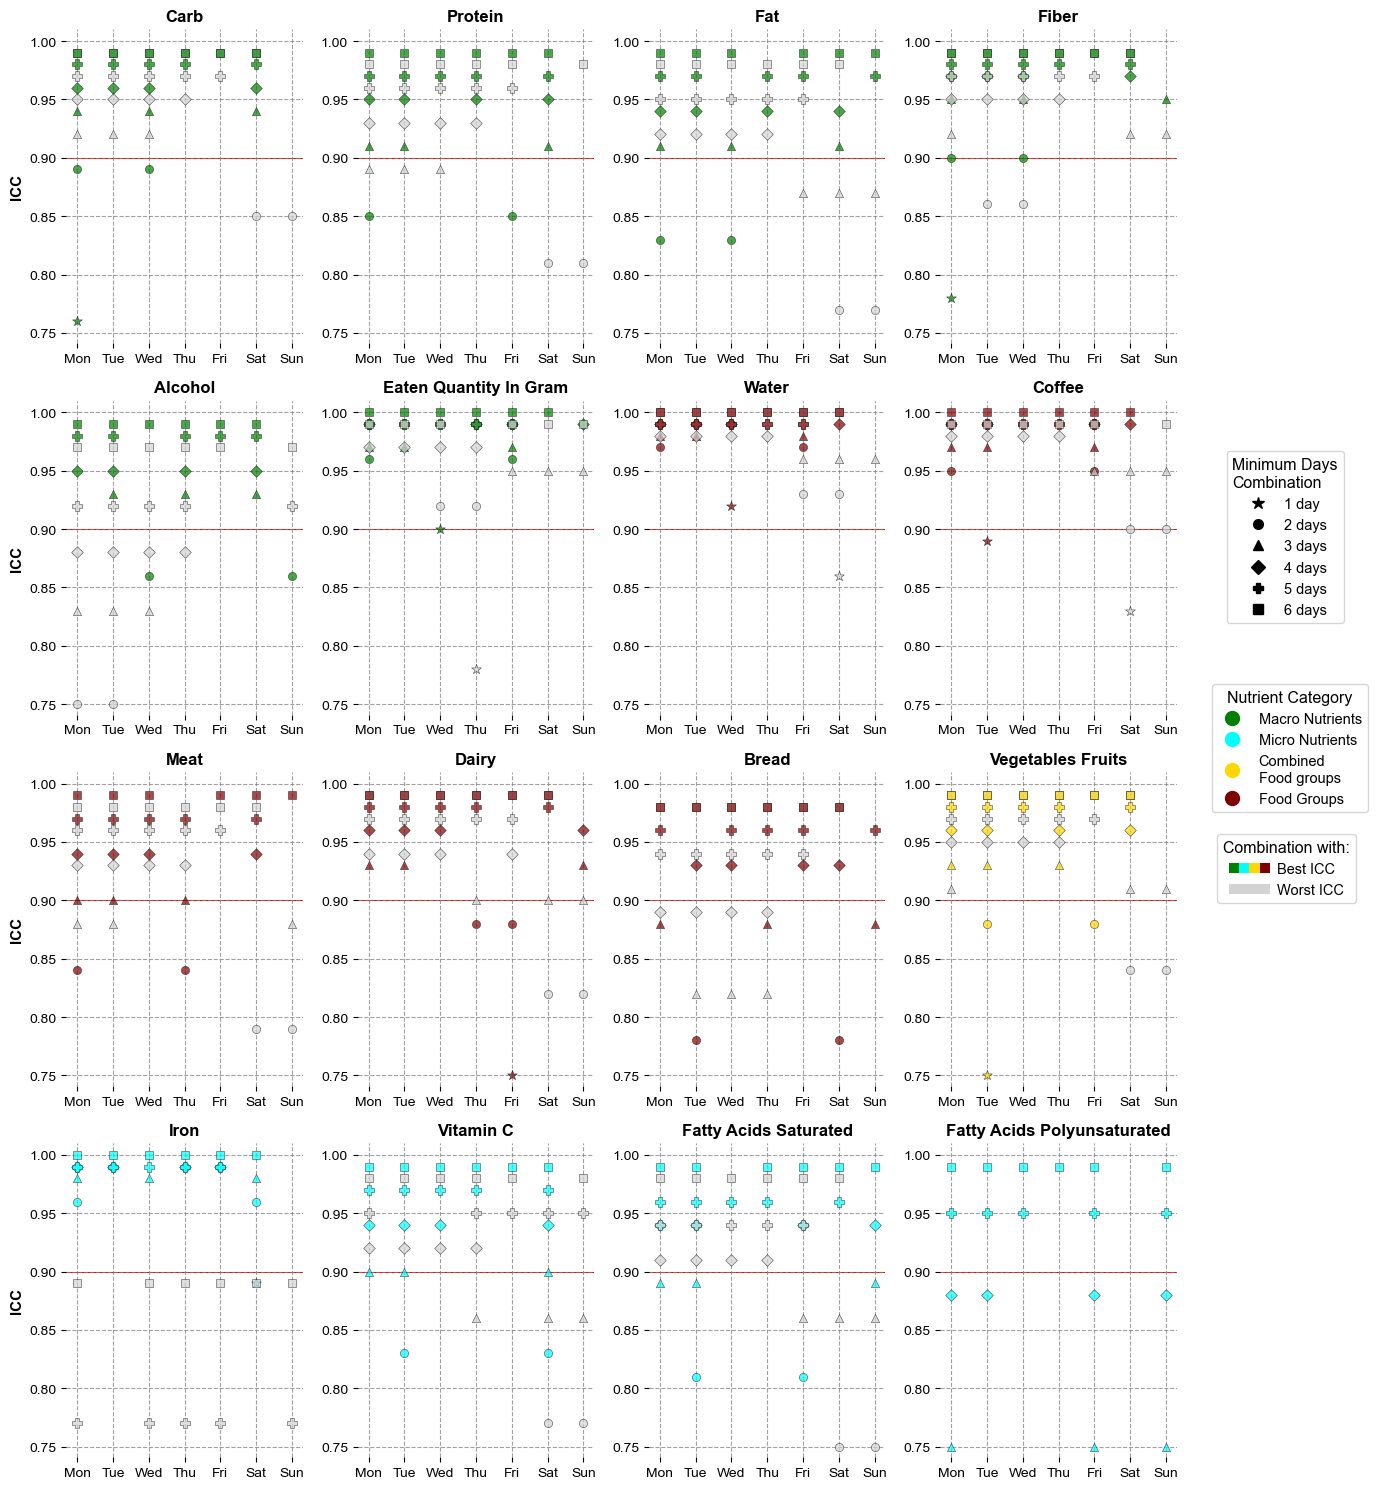

In [15]:
cols_to_plot = [
    "carb_eaten",
    "protein_eaten",
    "fat_eaten",
    "fiber_eaten",
    "alcohol_eaten",
    "eaten_quantity_in_gram",
    "water_fg_eaten",
    "coffee_fg_eaten",
    "meat_fg_eaten",
    "dairy_fg_eaten",
    "bread_fg_eaten",
    "vegetables_fruits",
    "iron_eaten",
    "vitamin_c_eaten",
    "fatty_acids_saturated_eaten",
    "fatty_acids_polyunsaturated_eaten",
]

plot_icc_combinations_big_wrapper(
    cols_to_plot=cols_to_plot,  # List of features to plot
    result=best_worst_day_combinations_with_days,
    file_name="figures/icc_min_daywise_combination_nobreaks.png",
    ncols=4,
    nrows=4,
    figsize=(12, 15),
    show_plot=True,
)

### Plotting ICC values for day combinations for food groups (supplementary figure )

14
14
dairy_products_meat_fish_eggs_tofu gold
sweets_salty_snacks_alcohol gold
non_alcoholic_beverages gold
grains_potatoes_pulses gold
oils_fats_nuts gold
fruits_fg_eaten maroon
vegetables_fg_eaten maroon
sugary_fg_eaten maroon
oils_nuts_fg_eaten maroon
grains_cereals_fg_eaten maroon
others_fg_eaten maroon
fast_food_fg_eaten maroon
vegan_fg_eaten maroon
tea_fg_eaten maroon


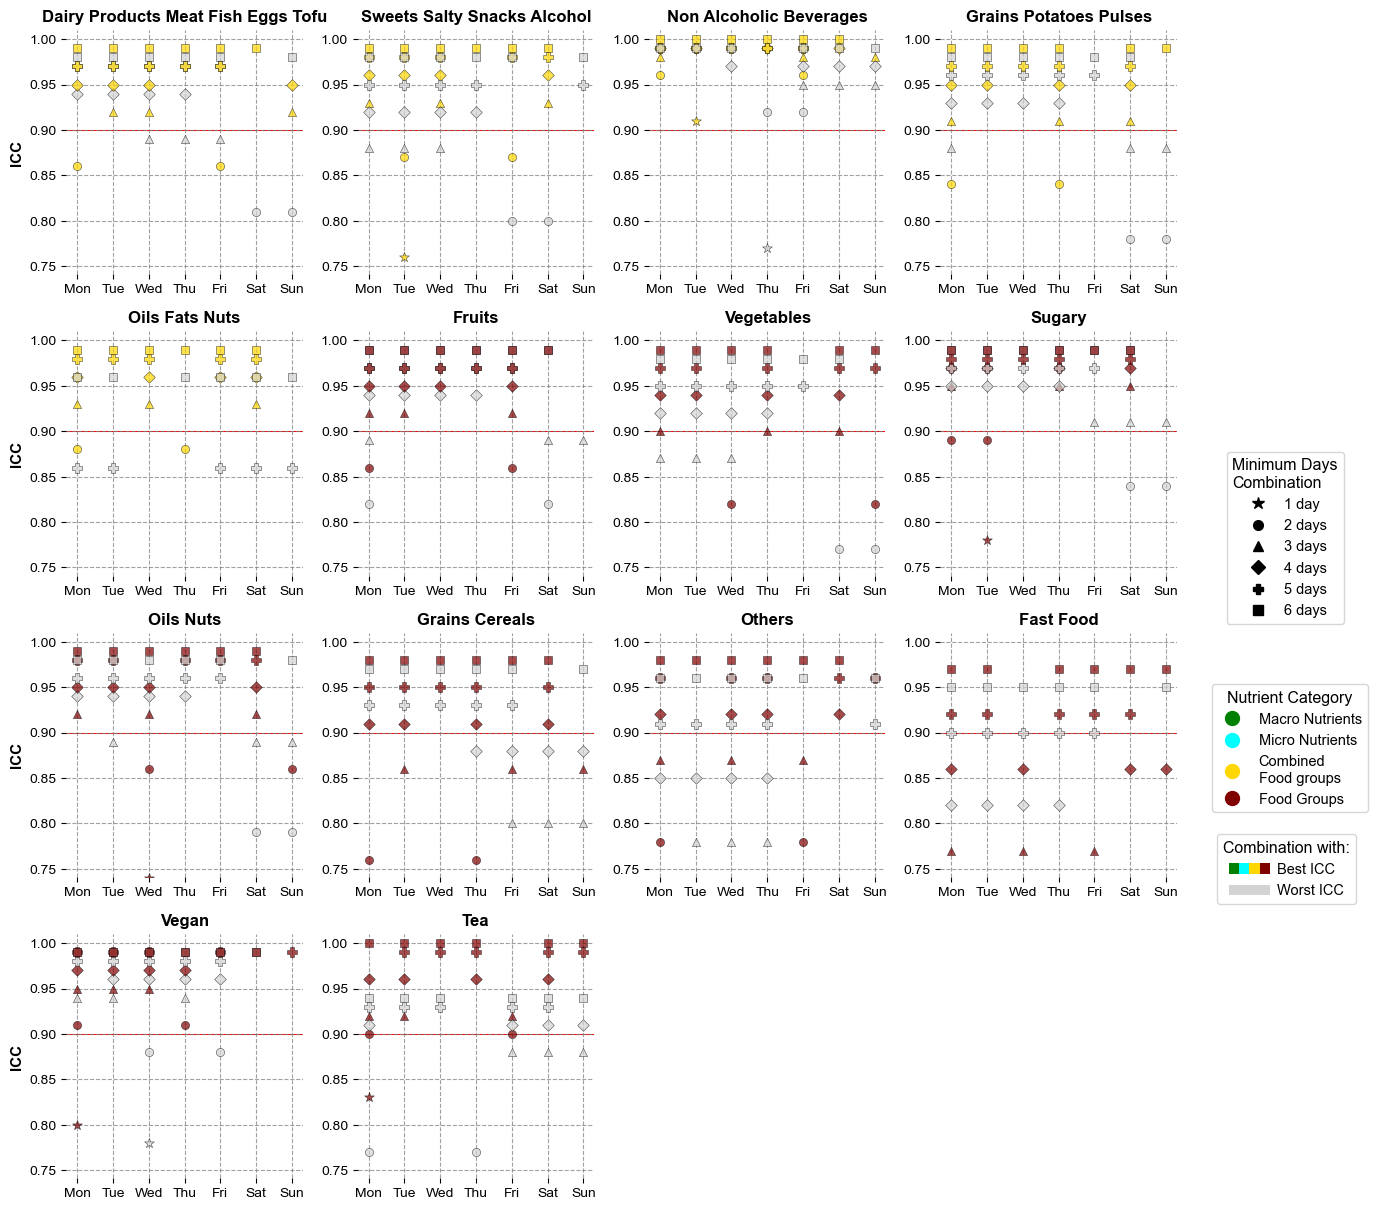

In [20]:
cols_to_plot_remaining_fg_cfg_vars = [
    i
    for i in best_worst_day_combinations_with_days["feature"].unique()
    if i not in cols_to_plot
    and i in nutri_fg_vars + nutri_cfg_vars
    and i not in ["energy_kj_eaten", "alcohol_fg_eaten"]
]
print(len(cols_to_plot_remaining_fg_cfg_vars))

plot_icc_combinations_big_wrapper(
    cols_to_plot=cols_to_plot_remaining_fg_cfg_vars,  # List of features to plot
    result=best_worst_day_combinations_with_days,
    file_name="figures/icc_min_daywise_combination_nobreaks_FoodGroups.png",
    ncols=4,
    nrows=5,
    figsize=(12, 15),
    show_plot=True,
)

### Plotting ICC values for day combinations for micronutrients (supplementary figure )

19
19
beta_carotene_eaten cyan
calcium_eaten cyan
cholesterol_eaten cyan
fatty_acids_monounsaturated_eaten cyan
folate_eaten cyan
magnesium_eaten cyan
niacin_eaten cyan
pantothenic_acid_eaten cyan
phosphorus_eaten cyan
potassium_eaten cyan
salt_eaten cyan
sodium_eaten cyan
sugar_eaten cyan
vitamin_b1_eaten cyan
vitamin_b12_eaten cyan
vitamin_b2_eaten cyan
vitamin_b6_eaten cyan
vitamin_d_eaten cyan
zinc_eaten cyan


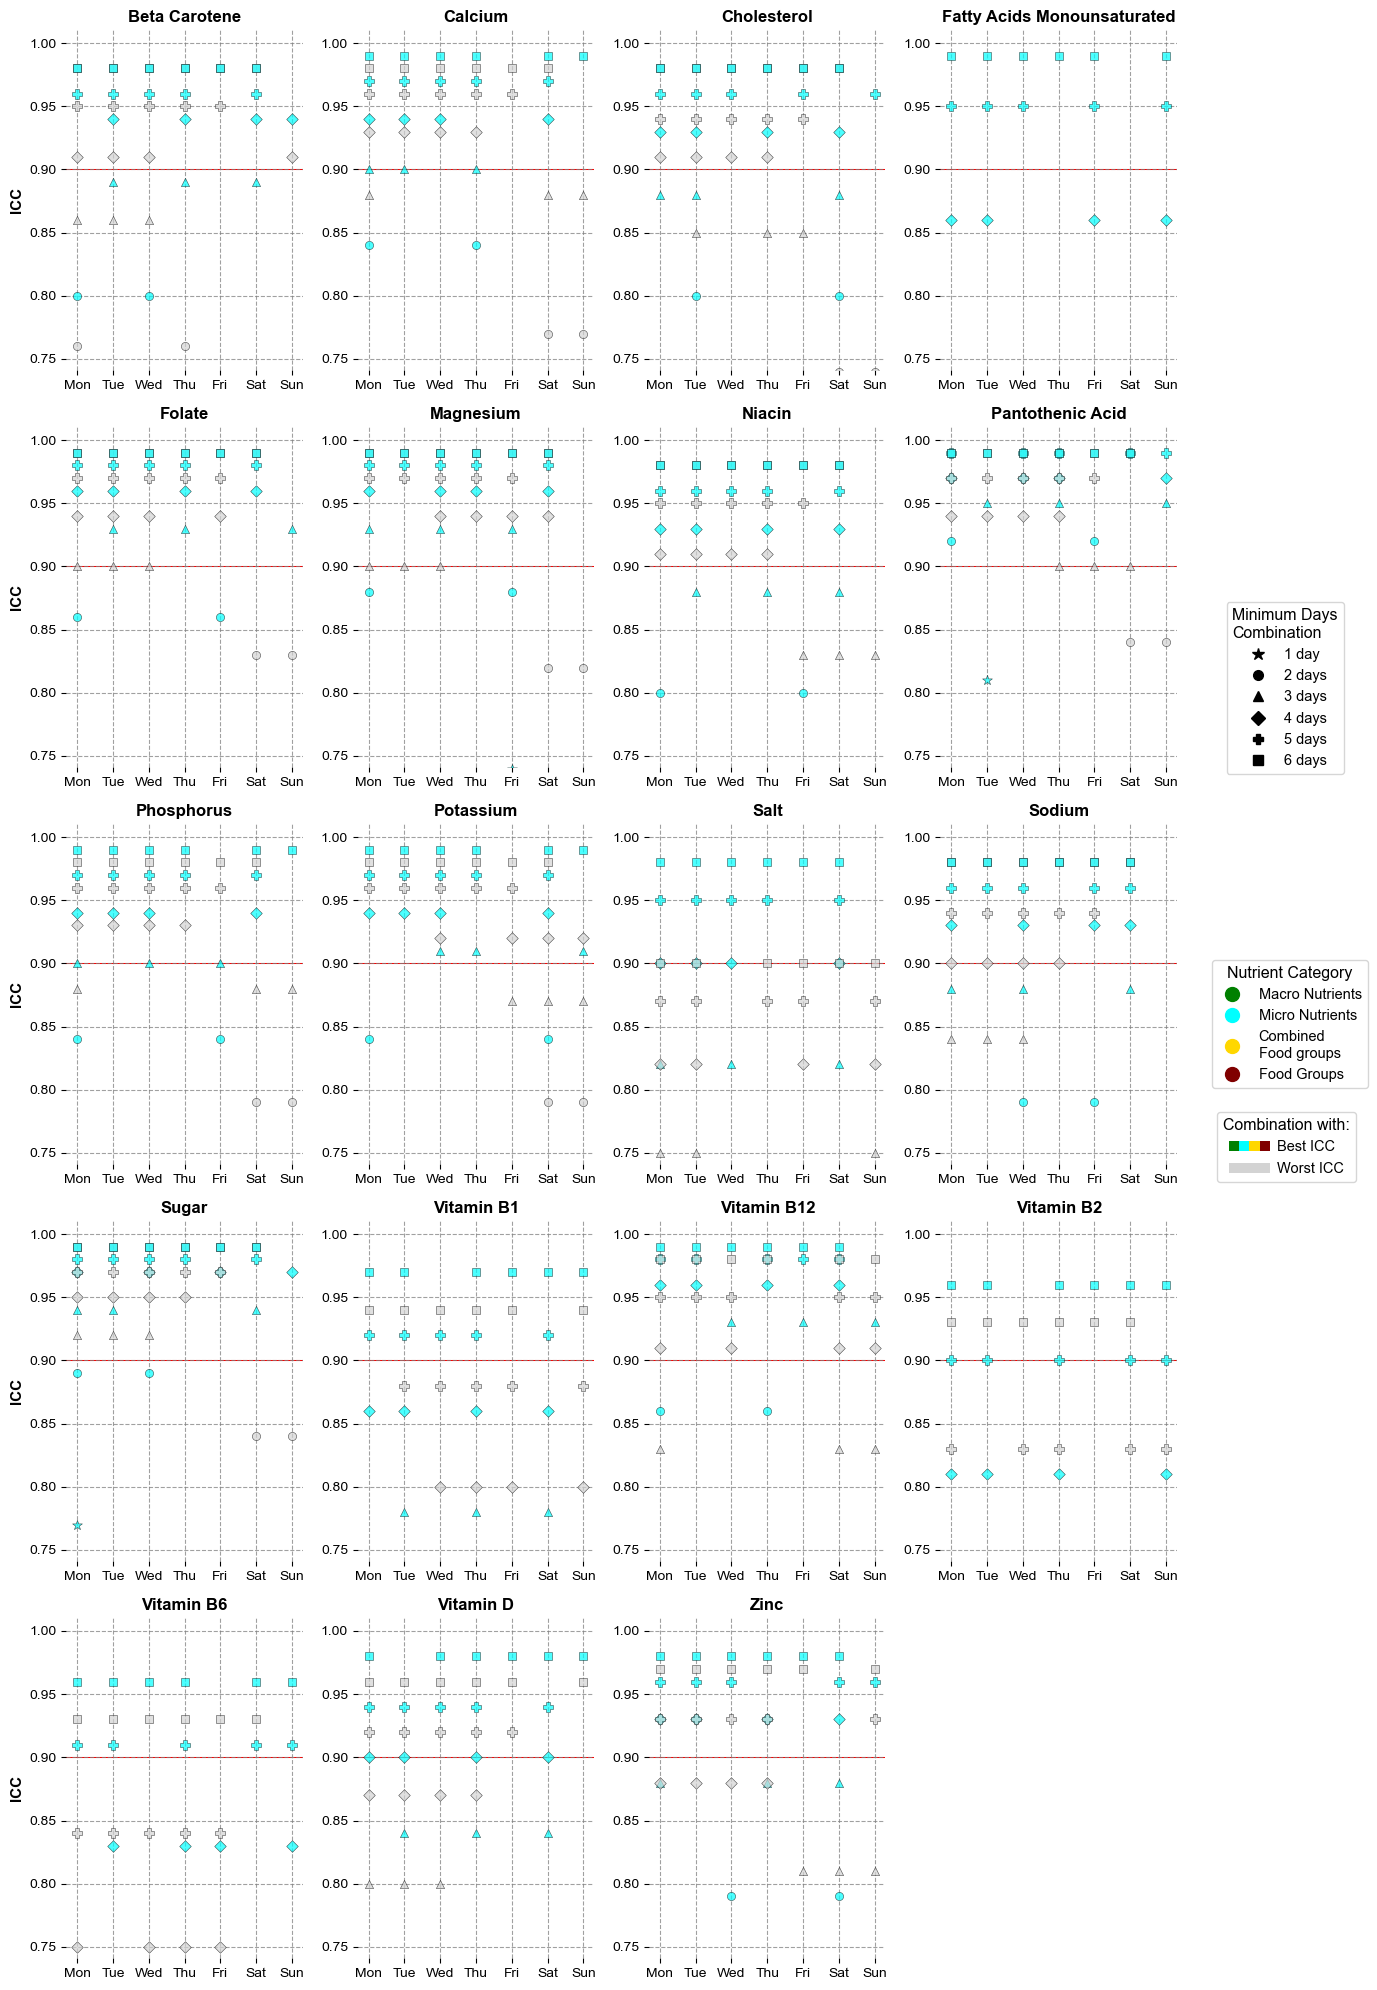

In [21]:
cols_to_plot_remaining_micronutrients = [
    i
    for i in best_worst_day_combinations_with_days["feature"].unique()
    if i not in cols_to_plot and i in nutri_micro_vars
]
print(len(cols_to_plot_remaining_micronutrients))

plot_icc_combinations_big_wrapper(
    cols_to_plot=cols_to_plot_remaining_micronutrients,  # List of features to plot
    result=best_worst_day_combinations_with_days,
    file_name="figures/icc_min_daywise_combination_nobreaks_micronutrients.png",
    ncols=4,
    nrows=5,
    figsize=(12, 20),
    show_plot=True,
)